## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU

from PIL import Image, ImageDraw
from random import seed
from random import random, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

## Load the dataset

### Generate Disk Image DataSet


In [2]:
w, h = 64, 64 # Image Size

#generate data for training
seed(1)
num_images_train=10000
radius_train=[]
x_train =[]
for i in range(num_images_train):
    value = uniform(0.1, 0.999)
    eX, eY = value*w, value*h #Size of Bounding Box for a disk (disk diameter)
    eX=round(eX,2)
    eY=eX
    radius_train.append(eX/2)    
    shape =  (w/2 - eX/2, h/2 - eY/2, w/2 + eX/2, h/2 + eY/2) # four corners the bounding box for a disk
    image = Image.new('L', (w, h), 'white')
    draw = ImageDraw.Draw(image)
    draw.ellipse(shape, fill = 'black', outline ='white')
    img_array=np.asarray(image)
    x_train.append(img_array)
    image.save('disk_data_train/disk'+str(i)+'.png')

x_train = np.array(x_train)
df_train=pd.DataFrame(radius_train)
df_train.to_csv('disk_data_train/radius_train.csv')

#generate data for testing 
seed(2)
num_images_test=2000
radius_test=[]
x_test= []
for i in range(num_images_test):
    value = uniform(0.1, 0.999)
    eX, eY = value*w, value*h #Size of Bounding Box for a disk (disk diameter)
    eX=round(eX,2)
    eY=eX
    radius_test.append(eX/2)    
    shape =  (w/2 - eX/2, h/2 - eY/2, w/2 + eX/2, h/2 + eY/2) # four corners the bounding box for a disk
    image = Image.new('L', (w, h), 'white')
    draw = ImageDraw.Draw(image)
    draw.ellipse(shape, fill = 'black', outline ='white')
    img_array=np.asarray(image)
    x_test.append(img_array)
    image.save('disk_data_test/disk'+str(i)+'.png')
    
x_test = np.array(x_test)    
x_test1 = x_test
df_test=pd.DataFrame(radius_train)
df_test.to_csv('disk_data_test/radius_test.csv')


### Guassian Blurring

In [3]:
# Blurring  5X5
# Blurring  5X5
x_train_blury = np.zeros((x_train.shape[0], 64, 64))
x_test_blury =  np.zeros((x_test.shape[0], 64, 64))
for i in range(x_train.shape[0]):
    x_train_blury[i] = cv2.GaussianBlur(x_train[i], (5, 5), 0)
for i in range(x_test.shape[0]):
    x_test_blury[i] =  cv2.GaussianBlur(x_test[i], (5, 5), 0)

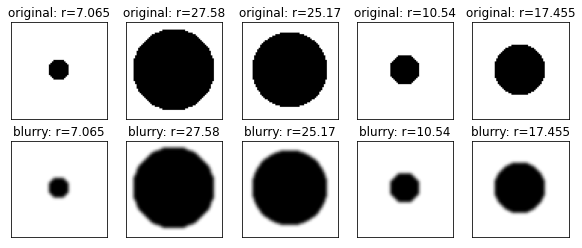

In [4]:
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original: r={}".format(radius_train[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_train_blury[i])
  plt.title("blurry: r={}".format(radius_train[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [5]:

x_train_blury = x_train.astype('float32') / 255.
x_test_blury  = x_test_blury.astype('float32') / 255.

print (x_train_blury.shape)
print (x_test_blury.shape)

(10000, 64, 64)
(2000, 64, 64)


## Basic autoencoder


Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [6]:
latent_dim = 1

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(4096, activation='sigmoid'),
      layers.Reshape((64, 64))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [8]:
autoencoder.fit(x_train_blury, x_train_blury,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_blury, x_test_blury))

Epoch 1/10
313/313 [==============================] - 1s 2ms/step - loss: 0.2292 - val_loss: 0.1953
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 0.1958 - val_loss: 0.1678
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 0.1735 - val_loss: 0.1497
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 0.1589 - val_loss: 0.1378
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 0.1492 - val_loss: 0.1298
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 0.1427 - val_loss: 0.1244
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 0.1383 - val_loss: 0.1207
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 0.1351 - val_loss: 0.1180
Epoch 9/10
313/313 [==============================] - 0s 1ms/step - loss: 0.1329 - val_loss: 0.1160
Epoch 10/10
313/313 [==============================] - 0s 1ms/step - loss: 0.1312 - val_loss: 0.1146

In [9]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1)                 4097      
                                                                 
 sequential_1 (Sequential)   (None, 64, 64)            8192      
                                                                 
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 1)                 4097      
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [11]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              8192      
                                                                 
 reshape (Reshape)           (None, 64, 64)            0         
                                                                 
Total params: 8,192
Trainable params: 8,192
Non-trainable params: 0
_________________________________________________________________


Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [12]:
encoded_imgs = autoencoder.encoder(x_test_blury).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

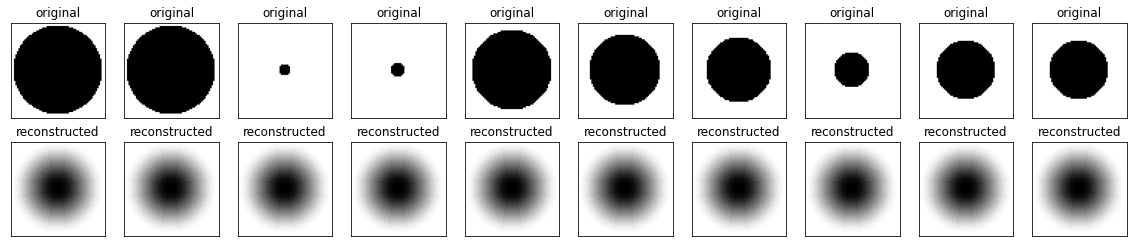

In [13]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional autoencoder with bias

#### Encoder
The encoder part is pretty standard, we stack convolutional and pooling layers and finish with a dense layer to get the representation of desirable size (code_size).

We recommend to use activation='elu' for all convolutional and dense layers.

We recommend to repeat (conv, pool) 4 times with kernel size (3, 3), padding='same' and the following numbers of output channels: 32, 64, 128, 256.

Remember to flatten (L.Flatten()) output before adding the last dense layer!


#### Decoder
For decoder we will use so-called "transpose convolution".

Traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transpose convolution" we want to take a number and produce a patch of an image (number -> patch). We need this layer to "undo" convolutions in encoder. We had a glimpse of it during week 3.


Here's how "transpose convolution" works:  In this example we use a stride of 2 to produce 4x4 output, this way we "undo" pooling as well. Another way to think about it: we "undo" convolution with stride 2 (which is similar to conv + pool).

You can add "transpose convolution" layer in Keras like this:
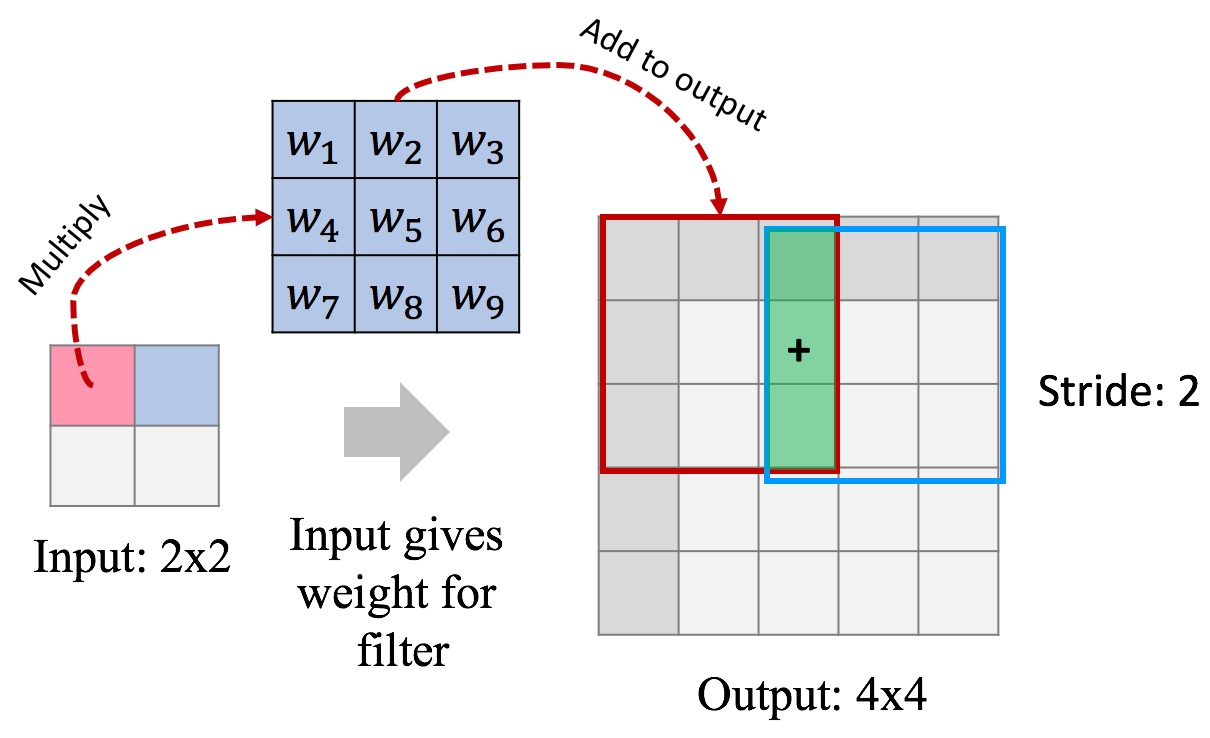

L.Conv2DTranspose(filters=?, kernel_size=(3, 3), strides=2, activation='elu', padding='same')
Our decoder starts with a dense layer to "undo" the last layer of encoder. Remember to reshape its output to "undo" L.Flatten() in encoder.

Now we're ready to undo (conv, pool) pairs. For this we need to stack 4 L.Conv2DTranspose layers with the following numbers of output channels: 128, 64, 32, 3. Each of these layers will learn to "undo" (conv, pool) pair in encoder. For the last L.Conv2DTranspose layer use activation=None because that is our final image.



In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [44]:
tf.keras.backend.clear_session()
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    decod_padding='valid'
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(64, 64,1), name='en1'),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', name='en2'),
      layers.MaxPooling2D((2, 2), name='en3'),
      layers.Conv2D(4, (3, 3), activation='relu', padding='same', name='en4'),
      layers.MaxPooling2D((2,2), name='en5'),
      layers.Conv2D(4, (3, 3), activation='relu', padding='same', name='en6'),
      layers.MaxPooling2D((2,2), name='en7'),
      layers.Conv2D(3, (3, 3), activation='relu', padding='same', name='en8'),
      layers.MaxPooling2D((2,2), name='en9'),
      layers.Conv2D(2, (3, 3), activation='relu', padding='same', name='en10'),
      layers.MaxPooling2D((2,2), name='en11'),
      layers.Conv2D(1, (3, 3), activation='relu', padding='same', name='en12'),
      layers.MaxPooling2D((2,2), name='en13'),  ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D((2,2), name='de1'),  
      layers.Conv2DTranspose(1,  kernel_size=3,    activation='relu', padding=decod_padding, name='de2', stride=2),
      #layers.UpSampling2D((2,2), name='de3'),  
      layers.Conv2DTranspose(2,  kernel_size=3,    activation='relu', padding=decod_padding, name='de4'),
      #layers.UpSampling2D((2,2), name='de5'),  
      layers.Conv2DTranspose(3,  kernel_size=3,    activation='relu', padding=decod_padding, name='de6'), 
      #layers.UpSampling2D((2,2), name='de7'),
      layers.Conv2DTranspose(4,  kernel_size=3,    activation='relu', padding=decod_padding, name='de8'),  
      #layers.UpSampling2D((2,2), name='de9'),
      layers.Conv2DTranspose(4, kernel_size=3,     activation='relu', padding=decod_padding, name='de10'),
      #layers.UpSampling2D((2,2), name='de11'),
      layers.Conv2DTranspose(8, kernel_size=3,     activation='relu', padding=decod_padding, name='de12'),
      #layers.UpSampling2D((2,2)), # ]),
      layers.Conv2D(1, kernel_size=3,     activation='relu', padding='same', name='de13') 
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [45]:
#MSE has the advantage of penalizing large errors amd making it more appropriate in some situations, s

In [46]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'] )

In [47]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 en2 (Conv2D)                (None, 64, 64, 8)         80        
                                                                 
 en3 (MaxPooling2D)          (None, 32, 32, 8)         0         
                                                                 
 en4 (Conv2D)                (None, 32, 32, 4)         292       
                                                                 
 en5 (MaxPooling2D)          (None, 16, 16, 4)         0         
                                                                 
 en6 (Conv2D)                (None, 16, 16, 4)         148       
                                                                 
 en7 (MaxPooling2D)          (None, 8, 8, 4)           0         
                                                                 
 en8 (Conv2D)                (None, 8, 8, 3)           1

In [51]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 de1 (UpSampling2D)          (None, 2, 2, 1)           0         
                                                                 
 de2 (Conv2DTranspose)       (None, 4, 4, 1)           10        
                                                                 
 de4 (Conv2DTranspose)       (None, 6, 6, 2)           20        
                                                                 
 de6 (Conv2DTranspose)       (None, 8, 8, 3)           57        
                                                                 
 de8 (Conv2DTranspose)       (None, 10, 10, 4)         112       
                                                                 
 de10 (Conv2DTranspose)      (None, 12, 12, 4)         148       
                                                                 
 de12 (Conv2DTranspose)      (None, 14, 14, 8)        

In [49]:
# data prepration into CONV2D
x_train_blury_cnn=x_train_blury[..., np.newaxis]
x_test_blury_cnn=x_test_blury[..., np.newaxis]

In [50]:
num_epochs = 5
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)
mc = ModelCheckpoint(
    "model", monitor="val_accuracy", mode="max", verbose=1, save_best_only=True)

hist1=autoencoder.fit(x_train_blury_cnn, x_train_blury_cnn,
                epochs=num_epochs,
                #batch_size=1000,
                shuffle=True,
                validation_data=(x_test_blury_cnn, x_test_blury_cnn))#, callbacks=[es, mc])

Epoch 1/5


ValueError: in user code:

    File "C:\Users\asfard1\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\asfard1\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\asfard1\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\asfard1\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\asfard1\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 949, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses)
    File "C:\Users\asfard1\AppData\Roaming\Python\Python37\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\asfard1\AppData\Roaming\Python\Python37\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\asfard1\AppData\Roaming\Python\Python37\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\asfard1\AppData\Roaming\Python\Python37\site-packages\keras\losses.py", line 1327, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 14 and 64 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](denoise/sequential_1/de13/Relu, IteratorGetNext:1)' with input shapes: [?,14,14,1], [?,64,64,1].


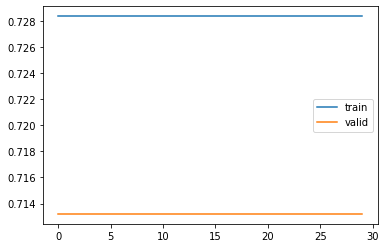

In [31]:
# Capturing learning history per epoch
hist = pd.DataFrame(hist1.history)
hist["epoch"] = hist1.epoch

# Plotting accuracy at different epochs
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend(("train", "valid"), loc=0)

Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [33]:
encoded_imgs = autoencoder.encoder(x_test_blury_cnn).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
decoded_imgs=  decoded_imgs[:, :, :,0]

In [34]:
decoded_imgs.shape

(2000, 64, 64)

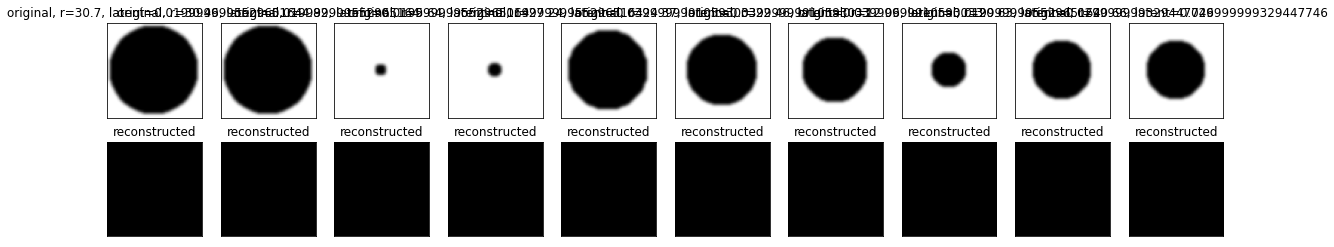

In [35]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test_blury[i])
  plt.title("original, r={}, latent={}".format(np.round(radius_test[i],2), np.round(encoded_imgs[i][0][0][0], 2) ) )
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### The autoencoder appears to represent the disks with their area.

In [51]:
from keras.models import Model
layer_name = 'en13'
intermediate_layer_model = Model(inputs=autoencoder.encoder.input,
                                 outputs=autoencoder.encoder.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_test_blury)

63/63 [==============================] - 0s 6ms/step


In [52]:
z=[]
area =[]
r=[]
for i in range(x_test.shape[0]):
    z.append(intermediate_output[i][0][0][0])
    area.append((radius_test[i]*radius_test[i]*np.pi))
    r.append(radius_test[i])

<AxesSubplot:title={'center':'inspect the latent space vs area'}, xlabel='z, latent space', ylabel='disk area'>

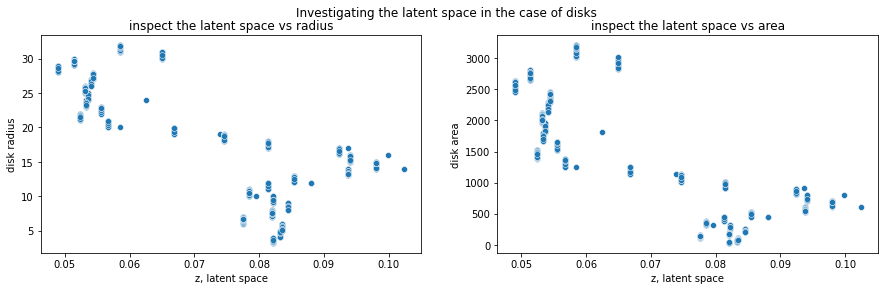

In [53]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,4))
fig.suptitle('Investigating the latent space in the case of disks')
axes[0].set_title('inspect the latent space vs radius')
axes[1].set_title('inspect the latent space vs area')
axes[0].set_xlabel('z, latent space')
axes[1].set_xlabel('z, latent space')
axes[0].set_ylabel('disk radius')
axes[1].set_ylabel('disk area')
sns.scatterplot(ax=axes[0], x=z, y=r)
sns.scatterplot(ax=axes[1], x=z, y=area)

Observations: 

1. Encoding a centred disk of a certain radius to a scalar z.
2. z seems to represent the area of input disks. 
3. The integration operation can be done by means of a simple cascade of linear filters. 
4. we should be able to encode the disks with a network containg only convolutions and sub-sampling, and no having non-linearities. 

### Training with Limited Radius

In [28]:
!pip install -U --user seaborn

Requirement already up-to-date: seaborn in c:\users\asfard1\appdata\roaming\python\python37\site-packages (0.11.2)


In [29]:

plt.histplot(data=radius_train)
plt.title('Radius Dist. in Train Set')
plt.xlabel(' Radius')

AttributeError: module 'matplotlib.pyplot' has no attribute 'histplot'

In [ ]:
sns.histplot(data=radius_test)
plt.title('Radius Dist. in Test Set')
plt.xlabel('Radius')

In [ ]:
h1=10
h2=20
x_train_h=[]
x_train_h_rad=[]
for i in range(x_train_blury_cnn.shape[0]):
    if radius_train[i]>20 or radius_train[i]<10 :
        x_train_h.append(x_train_blury_cnn[i])
        x_train_h_rad.append(radius_train[i])
x_train_h=np.array(x_train_h)

In [ ]:
sns.histplot(data=x_train_h_rad)
plt.title('Limited Train set, radius<15')
plt.xlabel(' Radius')

In [ ]:
tf.keras.backend.clear_session()
autoencoder_h = Denoise()
#autoencoder_h.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder_h.compile(optimizer='adam',     loss='mae', metrics=['mae'] )

num_epochs = 30
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)
mc = ModelCheckpoint(
    "model", monitor="val_accuracy", mode="max", verbose=1, save_best_only=True)

hist2=autoencoder_h.fit(x_train_h, x_train_h,
                epochs=num_epochs,
                batch_size=300,
                shuffle=True,
                validation_data=(x_test_blury_cnn, x_test_blury_cnn))

In [ ]:
# Capturing learning history per epoch
hist = pd.DataFrame(hist2.history)
hist["epoch"] = hist2.epoch

# Plotting accuracy at different epochs
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend(("train", "valid"), loc=0)

In [ ]:
encoded_imgs = autoencoder_h.encoder(x_test_blury_cnn).numpy()
decoded_imgs = autoencoder_h.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test_blury_cnn[i])
  plt.title("original, r={}".format(round(radius_test[i],2)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# extracting the output of last encoding layer (dimension 0)
from keras.models import Model
layer_name = 'en13'
intermediate_layer_model = Model(inputs=autoencoder_h.encoder.input,
                                 outputs=autoencoder_h.encoder.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_test_blury)

In [ ]:
z=[]
area =[]
for i in range(x_test.shape[0]):
    z.append(intermediate_output[i][0][0][0])
    area.append(radius_test[i])

In [ ]:
sns.scatterplot(area, z)
plt.axvline(x=h1)
plt.axvline(x=h2)
plt.title('inspect the latent space')
plt.ylabel('z, latent space')
plt.xlabel('disk radius')

In [ ]:
h1=15
h2=20
x_train_h=[]
x_train_h_rad=[]
for i in range(x_train_blury_cnn.shape[0]):
    if radius_train[i]>20 or radius_train[i]<10 :
        x_train_h.append(x_train_blury_cnn[i])
        x_train_h_rad.append(radius_train[i])
x_train_h=np.array(x_train_h)

In [ ]:
sns.histplot(data=x_train_h_rad)
plt.title('Limited Train set, radius<15')
plt.xlabel(' Radius')

In [ ]:
tf.keras.backend.clear_session()
autoencoder_h = Denoise()
#autoencoder_h.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder_h.compile(optimizer='adam',     loss='mae', metrics=['mae'] )

num_epochs = 30
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)
mc = ModelCheckpoint(
    "model", monitor="val_accuracy", mode="max", verbose=1, save_best_only=True)

hist2=autoencoder_h.fit(x_train_h, x_train_h,
                epochs=num_epochs,
                batch_size=300,
                shuffle=True,
                validation_data=(x_test_blury_cnn, x_test_blury_cnn))

In [ ]:
# Capturing learning history per epoch
hist = pd.DataFrame(hist2.history)
hist["epoch"] = hist2.epoch

# Plotting accuracy at different epochs
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend(("train", "valid"), loc=0)

In [ ]:
encoded_imgs = autoencoder_h.encoder(x_test_blury_cnn).numpy()
decoded_imgs = autoencoder_h.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test_blury_cnn[i])
  plt.title("original, r={}".format(round(radius_test[i],2)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# extracting the output of last encoding layer (dimension 0)
from keras.models import Model
layer_name = 'en13'
intermediate_layer_model = Model(inputs=autoencoder_h.encoder.input,
                                 outputs=autoencoder_h.encoder.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_test_blury)

In [ ]:
z=[]
area =[]
for i in range(x_test.shape[0]):
    z.append(intermediate_output[i][0][0][0])
    area.append(radius_test[i])

In [ ]:
sns.scatterplot(area, z)
plt.axvline(x=h1)
plt.axvline(x=h2)
plt.title('inspect the latent space')
plt.ylabel('z, latent space')
plt.xlabel('disk area')

Observations: 

1. Encoding a centred disk of a certain radius to a scalar z.
2. z seems to represent the area of input disks. 
3. The integration operation can be done by means of a simple cascade of linear filters. 
4. we should be able to encode the disks with a network containg only convolutions and sub-sampling, and no having non-linearities. 

## Convolutional autoencoder without bias

In [ ]:
# Blurring  5X5
#x_train_blury = np.zeros((x_train.shape[0], 64, 64))
#for i in range(x_train.shape[0]):
    #x_train_blury[i] = cv2.GaussianBlur(x_train[i], (5, 5), 0)
    x_train_blury[i] = x_train[i]

In [ ]:

x_train_blury = x_train.astype('float32') / 255.
x_test = x_test1.astype('float32') / 255.

print (x_train_blury.shape)
print (x_test.shape)

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(64, 64,1), name='en1'),
      layers.Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', name='en2', use_bias=False),
      layers.MaxPooling2D((2, 2), name='en3'),
      layers.Conv2D(4, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', name='en4', use_bias=False),
      layers.MaxPooling2D((2,2), name='en5'),
      layers.Conv2D(4, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', name='en6', use_bias=False),
      layers.MaxPooling2D((2,2), name='en7'),
      layers.Conv2D(3, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', name='en8', use_bias=False),
      layers.MaxPooling2D((2,2), name='en9'),
      layers.Conv2D(2, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', name='en10', use_bias=False),
      layers.MaxPooling2D((2,2), name='en11'),
      layers.Conv2D(1, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', name='en12', use_bias=False),
      layers.MaxPooling2D((2,2), name='en13')])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D((2,2), name='de1'),  
      layers.Conv2DTranspose(1,kernel_size=3, activation=LeakyReLU(alpha=0.2),padding='same', name='de2',use_bias=False),
      layers.UpSampling2D((2,2), name='de3'),  
      layers.Conv2DTranspose(2, kernel_size=3, activation=LeakyReLU(alpha=0.2),padding='same',name='de4',use_bias=False),
      layers.UpSampling2D((2,2), name='de5'),  
      layers.Conv2DTranspose(3, kernel_size=3, activation=LeakyReLU(alpha=0.2),padding='same',name='de6',use_bias=False), 
      layers.UpSampling2D((2,2), name='de7'),
      layers.Conv2DTranspose(4, kernel_size=3, activation=LeakyReLU(alpha=0.2),padding='same',name='de8', use_bias=False),  
      layers.UpSampling2D((2,2), name='de9'),
      layers.Conv2DTranspose(4, kernel_size=3, activation=LeakyReLU(alpha=0.2),padding='same',name='de10',use_bias=False),
      layers.UpSampling2D((2,2), name='de11'),
      layers.Conv2DTranspose(8, kernel_size=3, activation=LeakyReLU(alpha=0.2),padding='same',name='de12',use_bias=False),
      #layers.UpSampling2D((2,2)), # ]),
      layers.Conv2D(1, kernel_size=(3, 3),  padding='same', name='de13',use_bias=False) ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder_nobias = Denoise()

In [ ]:
autoencoder_nobias.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
num_epochs = 20
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)
mc = ModelCheckpoint(
    "model", monitor="val_accuracy", mode="max", verbose=1, save_best_only=True)

autoencoder_nobias.fit(x_train_blury, x_train_blury,
                epochs=num_epochs,
                batch_size=300,
                shuffle=True,
                validation_data=(x_test, x_test), callbacks=[es, mc])

In [ ]:
encoded_imgs = autoencoder_nobias.encoder(x_test).numpy()
decoded_imgs = autoencoder_nobias.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original, r={}".format(round(radius_test[i],2)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Observation: 
1. The decoder learns to spread the energy of z in the output
2. the goal of the biases is to shift the intermediary (hidden layer) images such that a cut-off can be carried out to create a satisfactory decoding.
